# Webscrapping in Python

## 1- Introduction

Web scraping is a technique used to extract information from websites. This lab will guide you through the basic steps of web scraping in Python using the requests and BeautifulSoup libraries.

Before starting, make sure you have installed the requests and BeautifulSoup libraries. You can install them via pip if you haven't already.

In [2]:
!pip install requests
!pip install bs4

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Program Files\Inkscape\bin\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Program Files\Inkscape\bin\python.exe -m pip install --upgrade pip


## Part 1:A first exemple

### 1- Loading libraries
We start by importing the necessary libraries for our web scraping task.

In [3]:
import requests

# https://requests.readthedocs.io/en/latest/

from bs4 import BeautifulSoup

# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### 2- Retrieving the content of a web page

We will retrieve the HTML content of a web page using requests. We will begin with the welcome page of the TSE website.


In [4]:
url = 'https://www.tse-fr.eu/'  # Remplacez par l'URL que vous souhaitez scraper
response = requests.get(url)


# Vérifions que la requête a réussi
if response.status_code == 200:
    print("Getting the page successfully")
else:
    print("Fail to get the page")

Getting the page successfully



### 3- Parsing the HTML content with BeautifulSoup

Once we have retrieved the HTML content, we can parse it with BeautifulSoup.


In [5]:
soup = BeautifulSoup(response.content, 'html.parser')



### 4- Extracting data

We will now extract specific data from the page. For example, we can extract all article titles (assuming the titles are in
tags). 

In [6]:
titles = soup.find_all('h2')
for title in titles:
    print(title.get_text())

Search form
About
People
Research
Study
Events
Get involved
News & Press

Season's Greetings from Toulouse School of Economics


17th Digital Economics Conference, January 9-10


Toulouse Summer School 2025: last days to apply


ABBAS Yasser’s PhD thesis December 17th, 2024

Admissions
All news
Debate
Selected publications
Job Market Candidates 2024-2025
Latest TSE Mag 
Alumni
Media
Giving to TSE
« Together, let's bridge the gap »
Key Figures



### 5- Saving the data

We can save the extracted data to a file for later analysis.


In [7]:
with open('titles.txt', 'w') as f:
    for title in titles:
        f.write(title.get_text() + '\n')


### 6- Analyzing and processing the data

You can now analyze and process the extracted data. For example, count the number of titles, find keywords, etc.


In [8]:
print(f"Nombre de titres extraits: {len(titles)}")

Nombre de titres extraits: 23


## Part B: A more complex example
We want now to get a dataframe of articles published by TSE researchers on the page . We want to save the title of the articles, its author, the publication date and the Thematic. For this,we will need to know the structure of the page. We can select an article on the page and click on Inspect to know how the page is built.
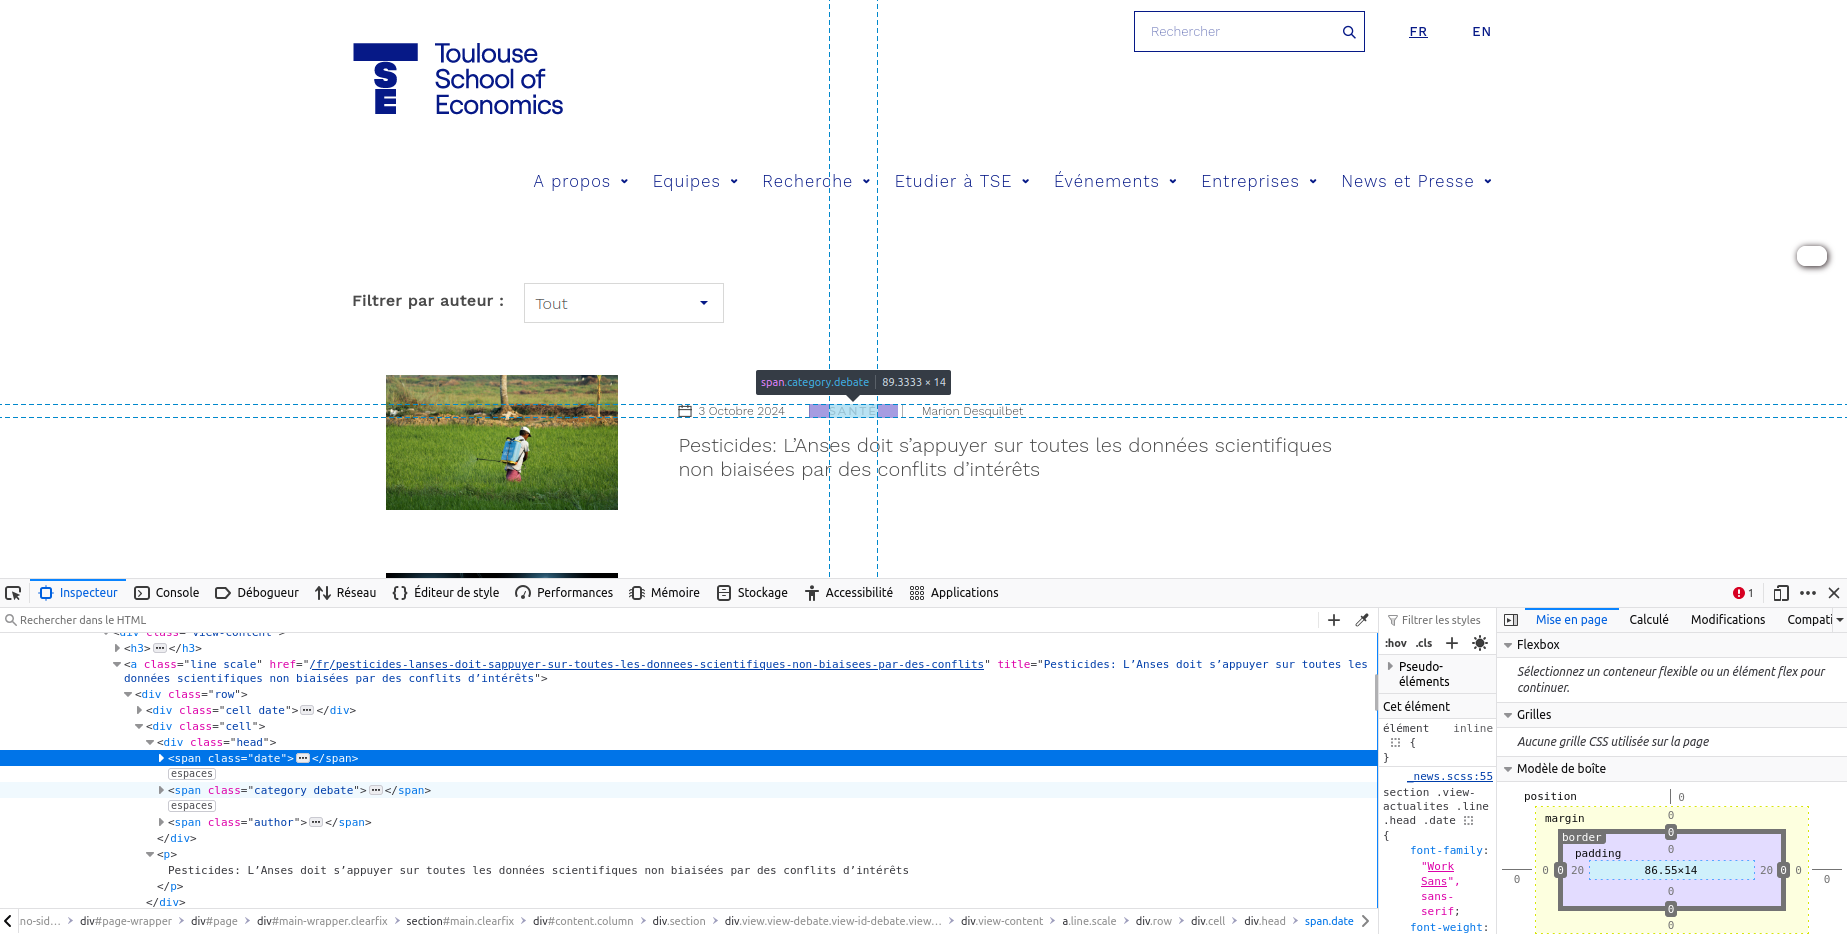
We see that each article is in a div whose class is row. The information that we want to get is in the div of class cell: the title is in the paragraph (in <p> </p>) and the date, author and thematic are in spans.

In [9]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd

url="https://www.tse-fr.eu/fr/debate/all"
article_class="row"
date_class="date"
author_class="author"
thematic_class="category debate"

#create an empty dataframe
articles=pd.DataFrame()

#get the content of the page
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
reviews=soup.find_all("div",class_=article_class)
for review in reviews:
    date=review.find("span",date_class).get_text()
    thematic=review.find("span",thematic_class).get_text()
    author=review.find("span",author_class).get_text()
    title=review.find("p").get_text()
    #use strip to remove newline
    new_article= pd.DataFrame.from_dict({'Title': [title.strip()],'Author' : [author.replace("\n", "")], 'Date' : [date], "Thematic": [thematic]} ) 
    if articles.empty:
        articles=new_article
    else:
        articles=pd.concat([articles,new_article],ignore_index=True)

articles.to_csv("TSE_articles.csv")
    


The code works we will check what we got.

In [10]:
print(articles)

                                               Title  \
0  Quel avenir pour les tarifs régulés de vente d...   
1         IA: techno-pessimisme ou techno-optimisme?   
2      TSE MAG 27 – L'IA va-t-elle guérir le monde ?   
3              TSE MAG 27 – Un jeu de vie et de mort   
4                      TSE MAG 27 – Tisser des liens   
5  TSE MAG 27 – La technologie nous déprime-t-elle ?   
6             TSE MAG 27 – Le bonheur est-il genré ?   
7                         TSE MAG 27 – Accès au soin   
8                             TSE MAG 27 – Vision 3V   
9                     TSE MAG 27 – Malbouffe toxique   

                                              Author              Date  \
0                        Stefan Ambec   &       C...  27 Novembre 2024   
1                        Frédéric Cherbonnier    ...  26 Novembre 2024   
2                        Pierre Dubois           ...  22 Novembre 2024   
3                                                     22 Novembre 2024   
4            

It works but we have only ten articles. Indeed, if we right-click on the website and select the Code source of the page, we see that there is a Show More link:
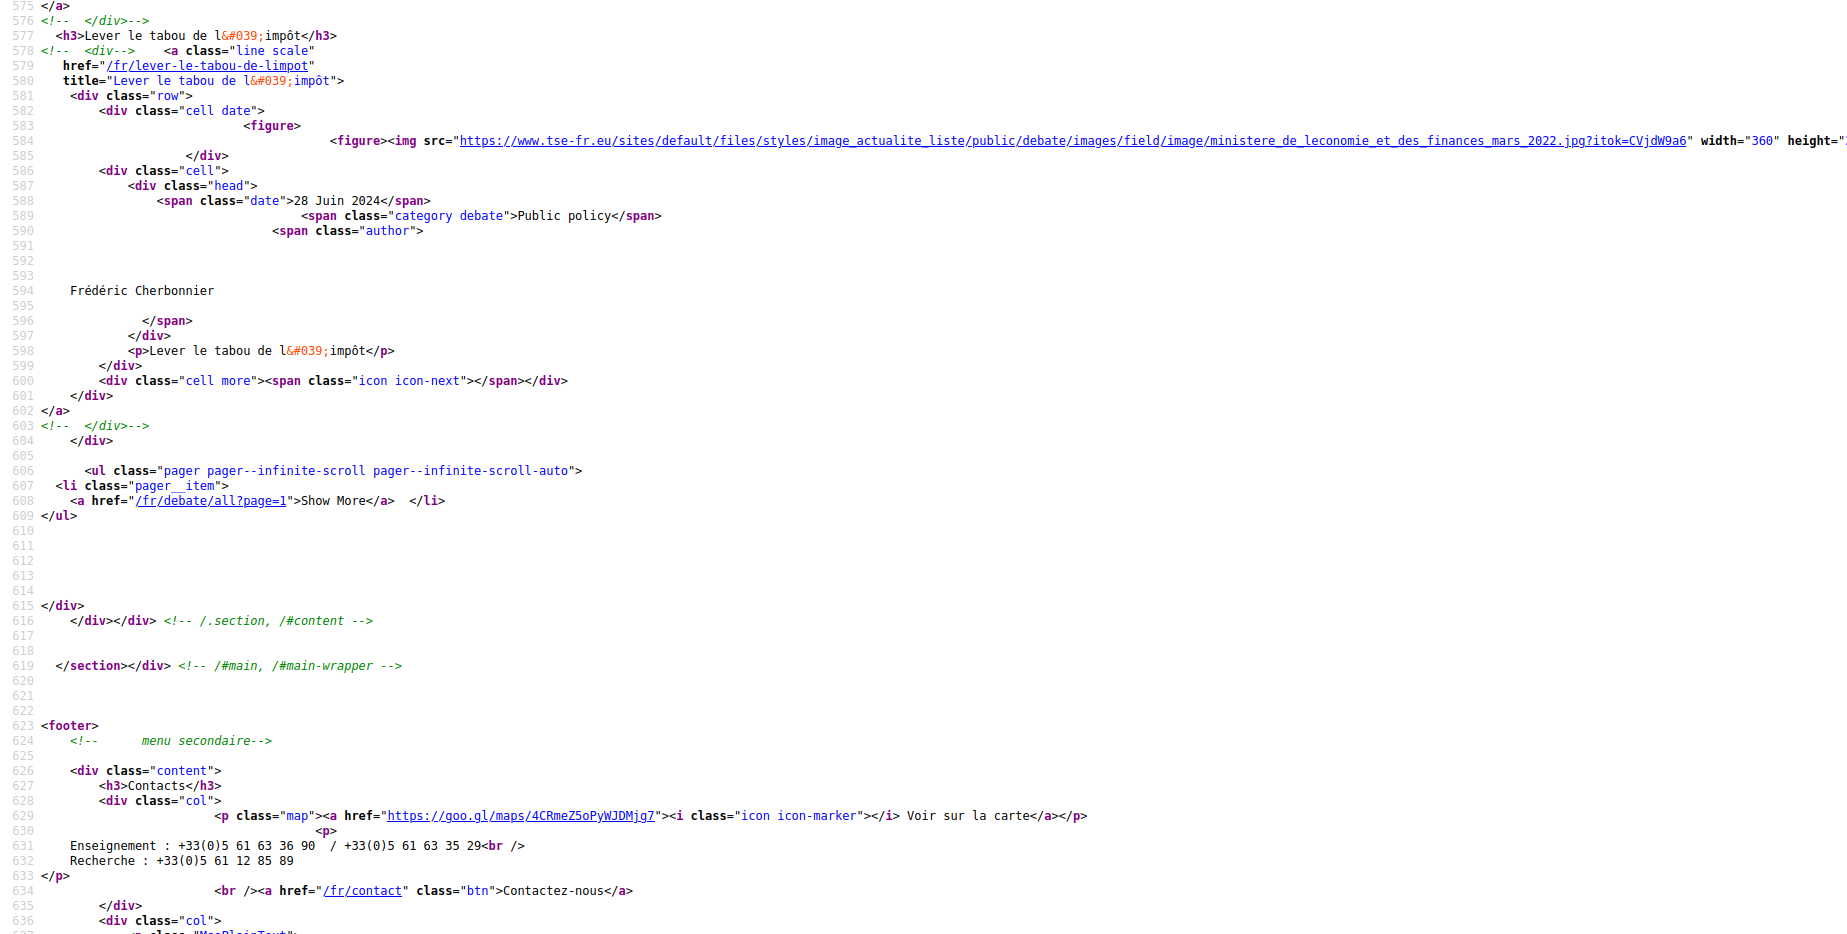
This links call the website with the argument page followed by a page number. Indeed, if we look to the network tab of the inspector, we see that when we scroll down, it creates a POST request for ajax:
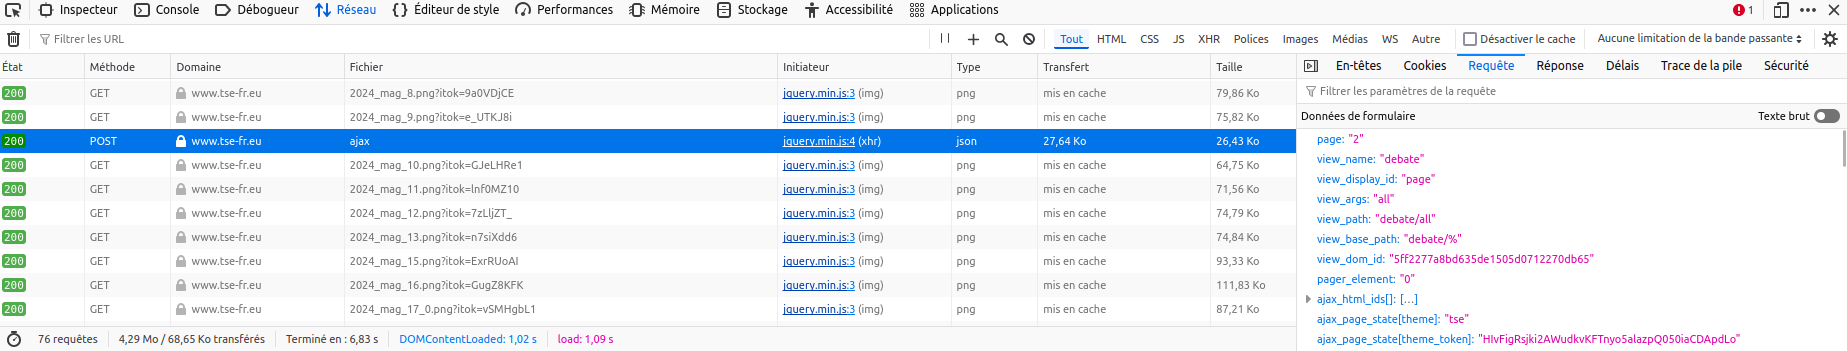
### Solution with BeautifulSoup
A first solution is to load the page by changing the page argument. We need to load a page, extract the articles then load the next page because when we request https://www.tse-fr.eu/fr/debate/all?page=10 we have only the articles on page 10.

In [11]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd

url = (
    "https://www.tse-fr.eu/fr/debate/all?page={}"
)
page = "1"

article_class="row"
date_class="date"
author_class="author"
thematic_class="category debate"
#show_more_class="pager__item"

#create an empty dataframe
articles=pd.DataFrame()

#get the content of the page
response = requests.get(url.format(page))
soup = BeautifulSoup(response.content, "html.parser")
while True:
    response = requests.get(url.format(page))
    soup = BeautifulSoup(response.content, "html.parser")
    # Find the show more link we should get the ul of class pager
    show_more = soup.find("ul", class_="pager")
    #get the li, the li contents a <a> </a>
    show_more=show_more.find("li").a
    if show_more is not None:
        #Then extract the href
        link=show_more.get('href')
        #The href has the form /fr/debate/all?page= so split the string
        page=link.split("=")[1]
        #extract the article of the page
        reviews=soup.find_all("div",class_=article_class)
        for review in reviews:
            date=review.find("span",date_class).get_text()
            thematic=review.find("span",thematic_class).get_text()
            author=review.find("span",author_class).get_text()
            title=review.find("p").get_text()
            #use strip to remove newline
            new_article= pd.DataFrame.from_dict({'Title': [title.strip()],'Author' : [author.replace("\n", "")], 'Date' : [date], "Thematic": [thematic]} ) 
            if articles.empty:
                articles=new_article
            else:
                articles=pd.concat([articles,new_article],ignore_index=True)
    else:
        #there is not Show more element anymore
        break



articles.to_csv("TSE_articles_bs.csv")

AttributeError: 'NoneType' object has no attribute 'get_text'

We can get all the pages but the code to fill the dataframe gives an error. If we load the last page, we can see that some articles don't have a thematic or an author:
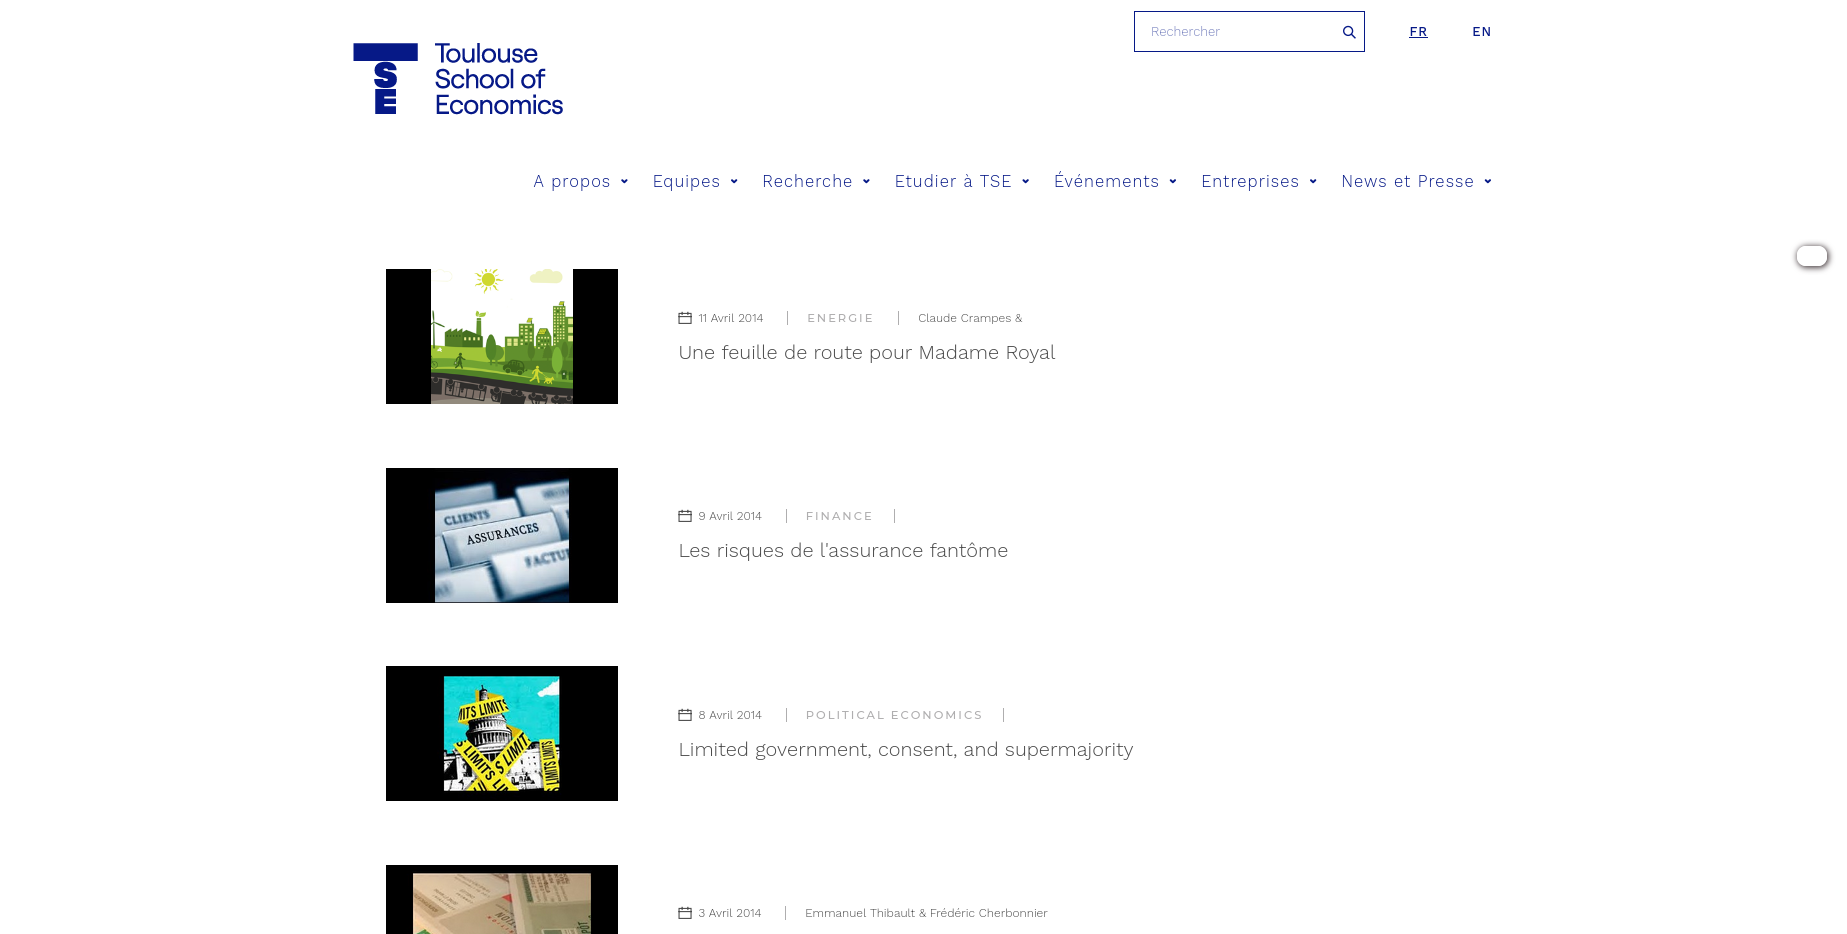

In [14]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd

url = (
    "https://www.tse-fr.eu/fr/debate/all?page={}"
)
page = "0"

article_class="row"
date_class="date"
author_class="author"
thematic_class="category debate"
#show_more_class="pager__item"

#create an empty dataframe
articles=pd.DataFrame()

#get the content of the page
response = requests.get(url.format(page))
soup = BeautifulSoup(response.content, "html.parser")
while True:
    response = requests.get(url.format(page))
    soup = BeautifulSoup(response.content, "html.parser")
    # Find the show more link we should get the ul of class pager
    show_more = soup.find("ul", class_="pager")
    #get the li, the li contents a <a> </a>
    show_more=show_more.find("li").a
    if show_more is not None:
        #Then extract the href
        link=show_more.get('href')
        #The href has the form /fr/debate/all?page= so split the string
        page=link.split("=")[1]
        #extract the articles of the page
        reviews=soup.find_all("div",class_=article_class)
        for review in reviews:
            date=review.find("span",date_class).get_text()
            thematic=review.find("span",thematic_class)
            #some thematic can be empty
            if thematic is not None:
                thematic=thematic.get_text()
            else:
                thematic=""
            try:
                author=review.find("span",author_class).get_text()
            except AttributeError:
               author=""
            title=review.find("p").get_text()
            #use strip to remove newline
            new_article= pd.DataFrame.from_dict({'Title': [title.strip()],'Author' : [author.replace("\n", "")], 'Date' : [date], "Thematic": [thematic]} ) 
            if articles.empty:
                articles=new_article
            else:
                articles=pd.concat([articles,new_article],ignore_index=True)

    else:
        #there is not Show more element anymore
        #extract articles of last pages
        reviews=soup.find_all("div",class_=article_class)
        for review in reviews:
            date=review.find("span",date_class).get_text()
            thematic=review.find("span",thematic_class)
            #some thematic can be empty
            if thematic is not None:
                thematic=thematic.get_text()
            else:
                thematic=""
            try:
                author=review.find("span",author_class).get_text()
            except AttributeError:
               author=""
            title=review.find("p").get_text()
            #use strip to remove newline
            new_article= pd.DataFrame.from_dict({'Title': [title.strip()],'Author' : [author.replace("\n", "")], 'Date' : [date], "Thematic": [thematic]} ) 
            if articles.empty:
                articles=new_article
            else:
                articles=pd.concat([articles,new_article],ignore_index=True)
        break



articles.to_csv("TSE_articles_bs.csv",index=False)

In [99]:
print(articles)

                                                 Title  \
0    Pesticides: L’Anses doit s’appuyer sur toutes ...   
1    Coopération européenne pour la mise au point d...   
2          Lutte contre la pauvreté: où est la gauche?   
3     Sommet du Bien Commun - Santé : l'espoir de l'IA   
4    Sommet du Bien Commun - Mettre fin à la pauvre...   
..                                                 ...   
621             Une feuille de route pour Madame Royal   
622                 Les risques de l'assurance fantôme   
623     Limited government, consent, and supermajority   
624  Fiscalité locale : il faut responsabiliser dav...   
625                         Des taxes contre l'obésité   

                                                Author               Date  \
0                          Marion Desquilbet       ...     3 Octobre 2024   
1                          Claude Crampes   &      ...  27 Septembre 2024   
2                          Frédéric Cherbonnier    ...  17 Septembre 202

It is great we get more articles. 
### Solution with selenium
An other solution is to use selenium package that allows you to automate browser and so to click on button or scroll down.
First check that it is installed

In [16]:
!pip install selenium

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [18]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException,StaleElementReferenceException 
import pandas as pd

In [28]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException,StaleElementReferenceException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

from selenium import webdriver


import pandas as pd

# option of the browser choose Firefox or Chrome
#options = webdriver.FirefoxOptions()
options=webdriver.ChromeOptions()
#run Selenium in headless mode
options.add_argument('--headless')
options.add_argument('--no-sandbox')

#create the driver for chrome on linux
wd = webdriver.Chrome(service=Service('/usr/bin/chromedriver'),options=options)

url='https://www.tse-fr.eu/fr/debate/all'
#get to the url
wd.get(url)

#selector
show_more_selector="li[class^=pager]>a"
article_selector="div[class='row']"
date_selector="span[class='date']"
author_selector="span[class='author']"
thematic_selector="span[class^=category]" #use class^= because the class name begins with category and selector can't contain spaces
title_selector="div[class='cell']>p"#"//div[@class='cell']/p"

#create a DataFrame empty
articles=pd.DataFrame()
#will contain the number of articles we stop to loop once we don't get new articles
lastLen=0
show_more= wd.find_elements(By.CSS_SELECTOR,show_more_selector)
while len(show_more)>0:
    try:
        #show_more= wd.find_elements(By.CSS_SELECTOR,show_more_selector)
        wd.execute_script("arguments[0].click();", show_more[-1])
        lastLocation=show_more[-1].location
        #print(show_more[-1].get_attribute("href"))
        wd.execute_script("window.scrollTo(arguments[0], arguments[1]);",lastLocation['x'],lastLocation['y'])
        #wd.execute_script("arguments[0].click();", show_more)
        show_more= wd.find_elements(By.CSS_SELECTOR,show_more_selector)
    except StaleElementReferenceException :
        show_more= wd.find_elements(By.CSS_SELECTOR,show_more_selector)

#We have scroll down up to the last articles we can extract all articles
results=wd.find_elements(By.CSS_SELECTOR,article_selector)

for art in results:
    title=art.find_element(By.CSS_SELECTOR,title_selector).text
    date=art.find_element(By.CSS_SELECTOR,date_selector).text
    try:
        author=art.find_element(By.CSS_SELECTOR,author_selector).text
    except NoSuchElementException:
        author=""
    try:
        thematic=art.find_element(By.CSS_SELECTOR,thematic_selector).text
    except NoSuchElementException:
        thematic=""
    new_article= pd.DataFrame.from_dict({'Title': [title.strip()],'Author' : [author.replace("\n", "")], 'Date' : [date], "Thematic": [thematic]} ) 
    if articles.empty:
        articles=new_article
    else:
        articles=pd.concat([articles,new_article],ignore_index=True)
        #articles=pd.concat([articles,new_article[new_article['Title'].isin(articles['Title'])==False]],ignore_index=True)

articles.to_csv("TSE_articles_se.csv",index=False)


In [149]:
print(articles)

                                                 Title  \
0    Pesticides: L’Anses doit s’appuyer sur toutes ...   
1    Coopération européenne pour la mise au point d...   
2          Lutte contre la pauvreté: où est la gauche?   
3     Sommet du Bien Commun - Santé : l'espoir de l'IA   
4    Sommet du Bien Commun - Mettre fin à la pauvre...   
..                                                 ...   
621             Une feuille de route pour Madame Royal   
622                 Les risques de l'assurance fantôme   
623     Limited government, consent, and supermajority   
624  Fiscalité locale : il faut responsabiliser dav...   
625                         Des taxes contre l'obésité   

                                       Author               Date  \
0                           Marion Desquilbet     3 Octobre 2024   
1           Claude Crampes & Gilles Lafforgue  27 Septembre 2024   
2                        Frédéric Cherbonnier  17 Septembre 2024   
3                              

## Part C :Webscrapping french maps archive

In [1]:
#installs (if needed) and imports
#!pip install requests
#!pip install beautifulsoup4

import requests
# https://requests.readthedocs.io/en/latest/

from bs4 import BeautifulSoup
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

import requests



Observe the structure of the page :

Go to : https://archives.haute-garonne.fr/

Search page for "archives figurés (Images archives)" : https://archives.haute-garonne.fr/archive/recherche/icono/n:2

But you need to set subject to : carte, cadastre, etc. Giving an url that look like : https://archives.haute-garonne.fr/archive/recherche/icono/n:2

Try a search then observe


In [5]:
#nb of results by page
limit = 20;

query = ''
page = 1

import re



url = f"https://archives.haute-garonne.fr/archive/resultats/icono/n:2?rech_s=toulouse&RECH_bdao=1&type=icono"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

response = requests.get(url, headers=headers)

print(url)

if response.status_code == 200:
    # print(response.content)
    soup = BeautifulSoup(response.content, 'html.parser')

    nbr_reponses_div = soup.find("span", class_="arc_nbr_reponses")
    nbr_reponses = nbr_reponses_div.text.strip() if nbr_reponses_div else "Nan"

    data_dict = {"nb_responses": nbr_reponses,
                  "requested_url" : url,
                  "records": []}

    divs = soup.find_all("div", id=lambda x: x and x.startswith('arc_vign_') and x.endswith('0'))

    ark_regex = re.compile(r'/ark:/\d+/[a-zA-Z0-9]+')

    for div in divs:

        record = {}
        record['id'] = div.get('id')

        # div_info = {}

        # Looking for the div image
        img_div = div.find("div", class_="arc_vignette_img")
        # If exists, extract the url
        if img_div and img_div.find("img"):
            record['image_url'] = img_div.find("img")['src']

        # Looking for the title div for the title
        descr_div = div.find("div", class_="title")
        # If exists, extract the text
        if descr_div:
            record['title'] = descr_div.text.strip()

        #extract the link element a to conserve a link to the source
        links = div.find_all("a", href=True)
        for link in links:
            href = link['href']
            if 'idsearch' in href:
                continue
            if ark_regex.match(href):
                record['ark_link'] = href
                break

        data_dict["records"].append(record)
     

https://archives.haute-garonne.fr/archive/resultats/icono/n:2?rech_s=toulouse&RECH_bdao=1&type=icono


In [6]:
data_dict

{'nb_responses': '66732 réponses dans 202 inventaires',
 'requested_url': 'https://archives.haute-garonne.fr/archive/resultats/icono/n:2?rech_s=toulouse&RECH_bdao=1&type=icono',
 'records': [{'id': 'arc_vign_331100_0',
   'image_url': 'https://archives.haute-garonne.fr/cgi-bin/iipsrv.fcgi?FIF=%2Fhome%2Fhttpd%2Fad31%2Fdiffusion%2Fprod%2Fapp%2Fwebroot%2Fdata%2Ffiles%2Fad31.diffusion%2Fimages%2Falto%2FGed45%2FThot%2FFI%2F2_O%2F2_O_12%2FFRAD031_00001_FI_000433%2FFRAD031_00001_FI_000433_0001.jpg&HEI=240&QLT=80&CVT=JPG&SIZE=430903&MTIME=1720183530',
   'title': '(1 vue)Carte des Chemins de S.[Saint-]Jacques de Compostelle 1648 / D. Derveaux, sculp. - Echelle : en lieues. - [s.l.] : [s.n.], [s.d.]. - Carte',
   'ark_link': '/ark:/44805/vtaa41437c25b1e8164/n:2'},
  {'id': 'arc_vign_333068_0',
   'image_url': 'https://archives.haute-garonne.fr/cgi-bin/iipsrv.fcgi?FIF=%2Fhome%2Fhttpd%2Fad31%2Fdiffusion%2Fprod%2Fapp%2Fwebroot%2Fdata%2Ffiles%2Fad31.diffusion%2Fimages%2Falto%2FGed45%2FThot%2FGedInt

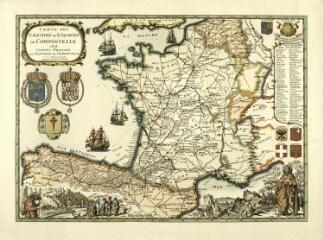

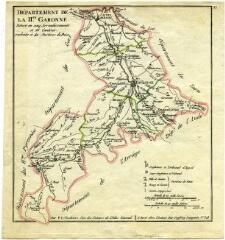

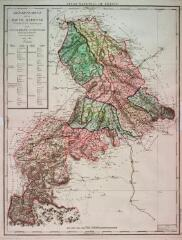

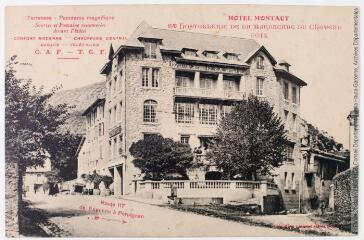

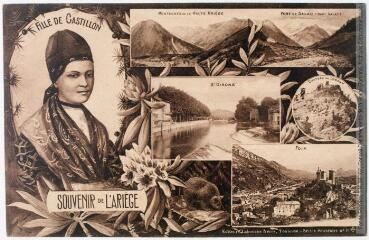

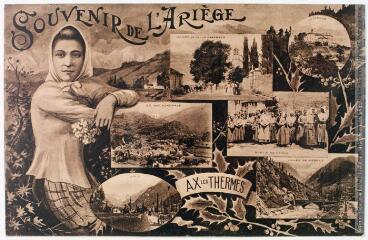

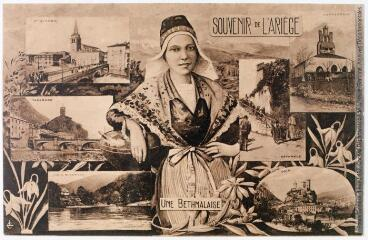

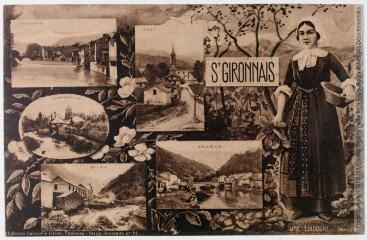

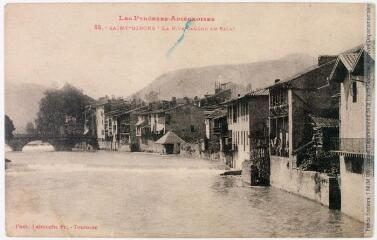

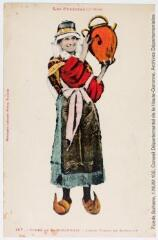

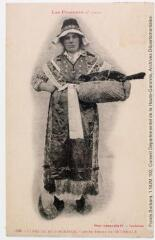

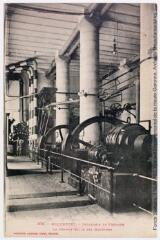

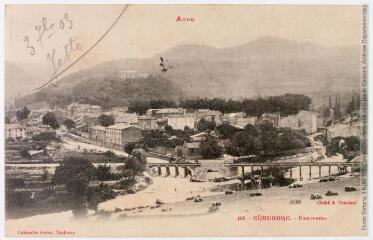

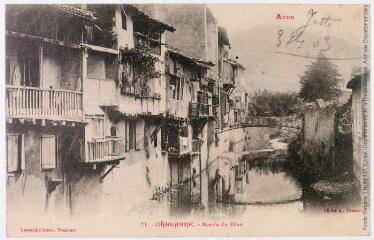

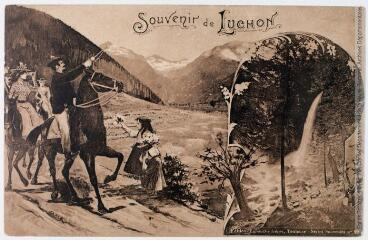

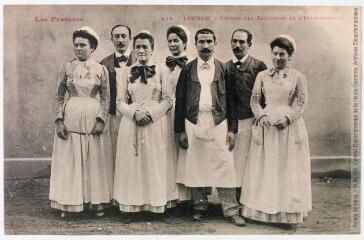

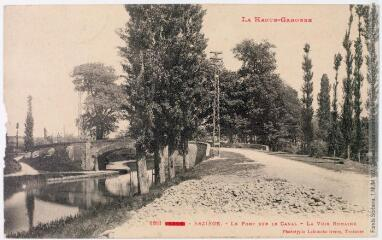

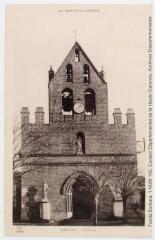

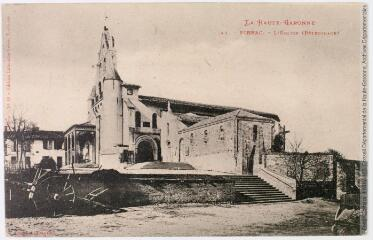

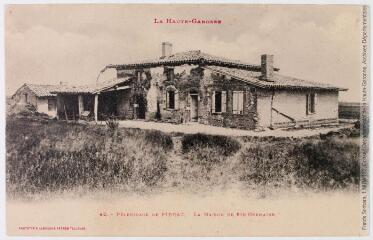

In [7]:
#Display

import requests
from IPython.display import display, Image
from PIL import Image as PILImage, UnidentifiedImageError
from io import BytesIO
from urllib.parse import urlparse, parse_qs


# Fonction pour extraire iiif highres de l'URL de l'image
def get_highres_url(image_url):
    # Extraire la valeur du paramètre FIF de l'URL

    #Because High res url looks like : https://archives.haute-garonne.fr/iiif/mnt/disk1/cache/ad31_diffusion/alto_jpg/Ged45/Thot/FI/2_O/2_O_12/FRAD031_00001_FI_000433/FOND.TIF/0,0,256,256/256,/0/native.jpg

    parsed_url = urlparse(image_url)
    query_params = parse_qs(parsed_url.query)

    fif_param = query_params.get('FIF', [None])[0]

    if fif_param:
        # Utiliser une expression régulière pour extraire la partie désirée
        pattern = re.compile(r'decoupepdf.*?(?=\.jpg)')
        match_url = pattern.search(fif_param)

        if match_url:
            highres_url = f'https://archives.haute-garonne.fr/iiif/mnt/disk1/cache/ad31_diffusion/{match_url.group(0)}/FOND.TIF/full/full/0/native.jpg'
            return highres_url

    return None
# Fonction pour afficher les vignettes
def display_thumbnails(records):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    for record in records:
        image_url = record['image_url']

        # Si l'URL ne contient pas le domaine, ajoutez-le
        if image_url.startswith('/'):
            image_url = 'https://archives.haute-garonne.fr' + image_url

        # Récupérer et afficher l'image
        try:
            response = requests.get(image_url, headers=headers)
            response.raise_for_status()
            img = PILImage.open(BytesIO(response.content))
            display(Image(data=response.content))
        except (requests.RequestException, UnidentifiedImageError) as e:
            print(f"Error fetching or displaying image {image_url}: {e}")

# Afficher les vignettes des images
display_thumbnails(data_dict['records'])



Have a look to https://dev.ptm.huma-num.fr/cartoquete/

for webscrapping on the fly
